# 神经网络 Neural Networks

对于这个练习，我们将再次处理手写数字数据集，这次使用反向传播的前馈神经网络。 我们将通过反向传播算法实现神经网络成本函数和梯度计算的非正则化和正则化版本。 我们还将实现随机权重初始化和使用网络进行预测的方法。

## 数据可视化 Visualizing the data

### 加载数据集

由于我们在练习3中使用的数据集是相同的，所以我们将重新使用代码来加载数据。

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pylab as plt
import seaborn as sns
import matplotlib

from scipy.io import loadmat

In [2]:
df = loadmat('ex4data1.mat')
X = df['X']
y = df['y']
X.shape,y.shape

((5000, 400), (5000, 1))

训练集中有5000个训练示例，其中每个训练示例是20像素*数字20像素的灰度图像。向量y中作为表示图像中数字的数字类。

### 绘制100个图像

In [3]:
def plot_100_image():
    index = np.random.choice(np.arange(X.shape[0]),100)
    
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8,8))
    for i in range(10):
        for j in range(10):
            pick_index  = index[i*10+j]
            ax[i,j].matshow(X[pick_index].reshape((20,20)), cmap=matplotlib.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

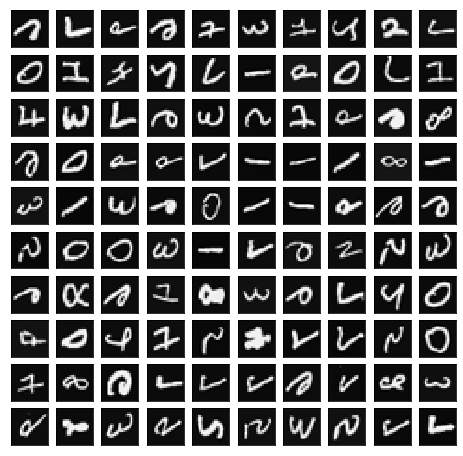

In [4]:
plot_100_image()

## 使用神经网络的步骤

1. `选择网络结构`，即决定选择多少层以及决定每层分别有多少个单元。

    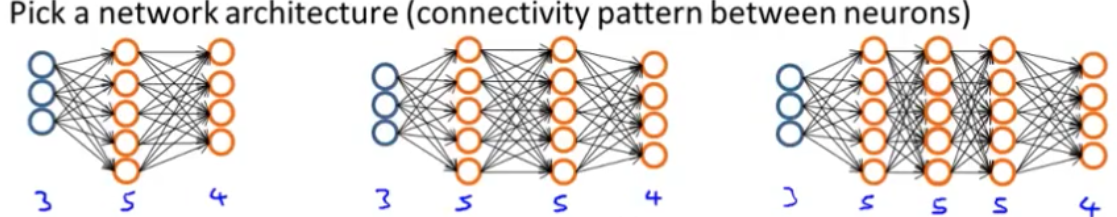

   - 第一层的单元数即我们训练集的特征数量。
   - 最后一层的单元数是我们训练集的结果的类的数量。
     - $y$需要用向量表示，如$y=[1,0,0,...,0]^T$，而不能直接用某个数值表示
     - 如果隐藏层数大于1，确保每个隐藏层的单元个数相同。如上图三个隐藏层均有5个隐藏单元。

   - 通常情况下隐藏层单元的个数越多越好。

   - 我们真正要决定的是隐藏层的层数和每个中间层的单元数。



2. 训练神经网络：
    - 参数的`随机初始化`
    - 利用`正向传播`方法计算所有的$h_{\theta}(x^{(i)})$ 
    - 编写计算`代价函数` $J(\Theta)$ 的代码
    - 利用`反向传播`方法计算所有偏导数$\frac{\partial}{\partial z^{(l)}_{j}}cost(i)$
        ​	具体参考 `9.3节反向传播算法(2)`
    - 利用`数值检验`方法检验这些偏导数
    - 使用优化算法来`最小化代价函数`

# 前馈预测 feed forward prediction

前向传播：我们从输入层的激励开始，然后前向传播给隐藏层并计算隐藏层的激励，然后我们继续前向传播，并计算输出层的激励。从输入层到隐藏层再到输出层依次计算激励的过程就叫做前向传播。

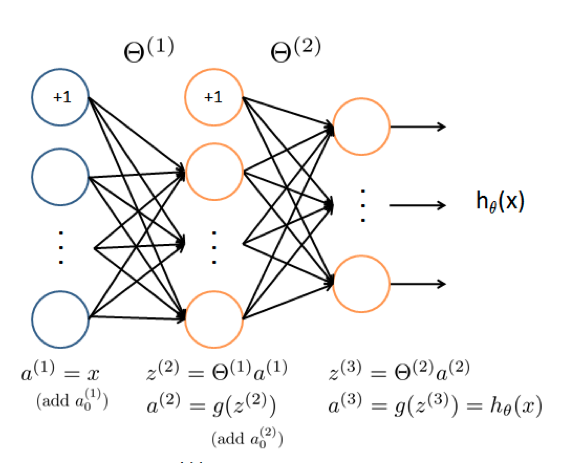

## 加载权重

已经提供了一组已经经过训练的矩阵参数$θ(1)，θ(2)$。 这些参数存储在`ex3weights.mat`中

In [5]:
def load_weight():
    data_weight = loadmat('ex4weights.mat')
    return data_weight['Theta1'], data_weight['Theta2']

In [6]:
W_theta_1, W_theta_2 = load_weight()

In [7]:
W_theta_1.shape, W_theta_2.shape

((25, 401), (10, 26))

- L = 3
- $m^{(1)}$ = 401, $m^{(2)}$ = 26, $m^{(3)}$ = 10

In [8]:
# 将原始数据转化为输入层的神经元时，需要添加偏置神经元
X = np.insert(X, 0,values=np.ones(X.shape[0]), axis=1)

In [9]:
X,X.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]), (5000, 401))

## 序列化数据

在本案例中，$\Theta^{(1)}$（25,401），$\Theta^{(2)}$（10,26），相对应的它们的梯度分别是$\Delta^{(1)}$，$\Delta^{(2)}$

In [10]:
# 序列化数据
def serialize(data_1,data_2):
    return np.concatenate(  (np.ravel(data_1),np.ravel(data_2))  )

In [11]:
# 还原序列化后的数据
def deserialize(seq):
    return seq[:25*401].reshape(25,401), seq[25*401:].reshape(10,26)

- 测试

In [12]:
W_theta = serialize(W_theta_1,W_theta_2)
W_theta.shape

(10285,)

In [13]:
a, b = deserialize(W_theta)
a.shape, b.shape

((25, 401), (10, 26))

## 前馈神经网络 feedforward neural network

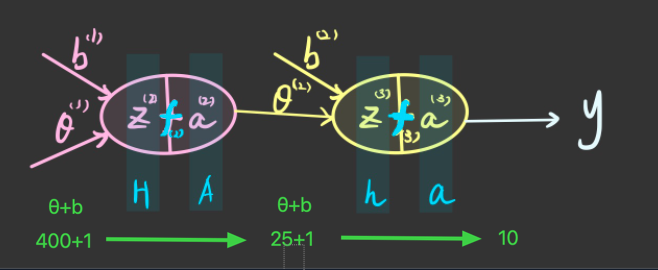

使用前向传播来计算一下在给定输入的时候，假设函数是否会真的输出结果。具体地说，这里的$a^{(1)}$就是第一层的激励值，也就是输入层所在的地方，所以设定它为$x$。$a^{(2)}$是隐藏层也就是第二层的激励值,经过一个S型激励函数$g(z)$，同时还会增加一个偏差单元$b^{(2)}$,然后可以得出后续的$a^{(3)},a^{(4)}$。

其中：
$$
g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\
$$

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
def forward_propagate(X,theta):
    # a1为输入层 ，隐藏层有两层，h为输出层
    theta1, theta2 = deserialize(theta)
    
    a1 = X
    
    z2 = a1 @ theta1.T    # a1(5000, 401) theta1(25, 401)  z2(5000,25)
    a2 = sigmoid(z=z2)  
    
    a2 = np.insert(a2,0,values=np.ones(X.shape[0]),axis=1)   # 增加一个偏差单元 (5000,1)
    z3 = a2 @ theta2.T   # a2(5000,26)    theta2(10,26)  z3(5000,10)
    a3 = sigmoid(z=z3)
  
    h = a3
    return  a1, z2, a2, z3, h

In [16]:
a1, z2, a2, z3, h = forward_propagate(X=X,theta=W_theta)
h.shape

(5000, 10)

## 用训练集预测和验证

我们选择训练集中$h(x)$的最大值作为预测结果

In [17]:
def predict(h):
    h_max = np.argmax(h,axis=1)   # 按行取 返回索引 由于数组从0开始因此+1
    return h_max + 1

In [18]:
p = predict(h)
p

array([10, 10, 10, ...,  9,  9,  9])

In [19]:
# 对比目标变量y 计算精准度
# zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
def accuracy(predictions,y):
    currectList = []
    for (a,b) in zip(predictions,y):
        if a==b :
            currectList.append(1)
        else:
            currectList.append(0)
    accuracy = sum(map(int,currectList)) / len(currectList)  # 精准度
    return accuracy,currectList

In [20]:
acc,accList = accuracy(predictions=p,y=y)
print('精准度为{}%'.format(acc*100))

精准度为97.52%


# 训练神经网络

## 选择网络结构 Pick a network architecture

- 第一层的单元数即我们训练集的特征数量。
- 我们真正要决定的是隐藏层的层数和每个中间层的单元数。
- 最后一层的单元数是我们训练集的结果的类的数量。


已知：
1.  L = 3
2.  $𝑚^{(1)}  = 401,  𝑚^{(2)}  = 26,  𝑚^{(3)}  = 10$

In [21]:
inputSize = 400   # 输入层 400+1
hiddenSize = 25   # 隐藏层 25+1
outputSize = 10   # 输出层 10
learningRate = 1  # 学习率

### One-Hot 编码

One-Hot编码，又称为一位有效编码，主要是采用N位状态寄存器来对N个状态进行编码，每个状态都由他独立的寄存器位，并且在任意时候只有一位有效。

One-Hot编码是分类变量作为二进制向量的表示。这首先要求将分类值映射到整数值。然后，每个整数值被表示为二进制向量，除了整数的索引之外，它都是零值，它被标记为1。


例：性别特征：["男","女"]

- 男  =>  10

- 女  =>  01

祖国特征：["中国"，"美国，"法国"]（这里N=3）：

- 中国  =>  100

- 美国  =>  010

- 法国  =>  001

运动特征：["足球"，"篮球"，"羽毛球"，"乒乓球"]（这里N=4）：

- 足球  =>  1000

- 篮球  =>  0100

- 羽毛球  =>  0010

- 乒乓球  =>  0001

所以，当一个样本为["男","中国","乒乓球"]的时候，完整的特征数字化的结果为：

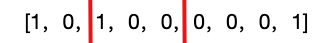

我们也需要对我们的y标签进行一次One-Hot编码。`Scikit-learn`有一个内置的实用程序，我们可以使用这个。

In [22]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')   # 指定编码格式不执行toarray()
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [23]:
# 转化为matrix矩阵
X = np.matrix(X)
y = np.matrix(y_onehot)
X.shape

(5000, 401)

## 随机初始化 random initialization

任何优化算法都需要一些初始的参数。我们通常初始参数为$\Theta_{ij}^{(l)}$为$[-\epsilon,\epsilon]$之间的随机值.

如果一个网络在第$j$层有$s_j$个单元，在$j+1$层有$s_{j+1}$个单元，那么矩阵$\Theta^{(j)}$，即控制第$j$层到第$j+1$层映射的矩阵的，维度为

$$
s_{j+1}×(s_j+1)
$$

​				所以$\Theta^{(j)}$的维度是，$s_{j+1}$行，$s_j+1$列。   

In [24]:
# 1. 随机初始化 完整网络参数大小的 参数数组
matrixSize = hiddenSize * (inputSize+1)  + outputSize * (hiddenSize+1)
#    np.random.random(size=) 生成随机浮点数
randomParams = (np.random.random(size=matrixSize)-0.5)*0.25
randomParams

array([-0.09026805, -0.05400499,  0.10229874, ...,  0.04536803,
        0.08927297, -0.06914866])

In [25]:
# 2. 将参数数组解开为每个层的参数矩阵
#    A = reshape(a=A，newshape=(i,j)) 将A的行列排列成i行j列。
theta_1_size = np.reshape(a=randomParams[:hiddenSize * (inputSize+1)],
                          newshape=(hiddenSize,(inputSize+1))
                         )
theta_2_size = np.reshape(a=randomParams[hiddenSize * (inputSize+1):],
                          newshape=(outputSize,(hiddenSize+1))
                         )
theta_1 = np.matrix(theta_1_size)
theta_2 = np.matrix(theta_2_size)

theta = serialize(theta_1_size , theta_2_size)

In [26]:
# 重写反序列化函数
def deserialize(seq):
    return seq[:hiddenSize * (inputSize+1)].reshape(hiddenSize,(inputSize+1)),seq[hiddenSize * (inputSize+1):].reshape(outputSize,(hiddenSize+1))

In [27]:
# 同理：
theta_1,theta_2 = deserialize(randomParams)
theta = randomParams

In [28]:
# 3. 确认参数矩阵的维度
theta_1.shape,theta_2.shape,theta.shape
# θ1(25,401), θ2(10,26)

((25, 401), (10, 26), (10285,))

## 前馈神经网络 feedforward neural network

In [29]:
def forward_propagate(X,theta):
    # a1为输入层 ，隐藏层有两层，h为输出层
    theta1, theta2 = deserialize(theta)
    
    a1 = X
    
    z2 = a1 @ theta1.T    # a1(5000, 401) theta1(25, 401)  z2(5000,25)
    a2 = sigmoid(z=z2)  
    
    a2 = np.insert(a2,0,values=np.ones(X.shape[0]),axis=1)   # 增加一个偏差单元 (5000,1)
    z3 = a2 @ theta2.T   # a2(5000,26)    theta2(10,26)  z3(5000,10)
    a3 = sigmoid(z=z3)
  
    h = a3
    return  a1, z2, a2, z3, h

In [30]:
a1, z2, a2, z3, h = forward_propagate(X=X,theta=theta)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

## 代价函数 cost function

### 代价函数

反向传播算法不考虑正则化的代价函数为：

$$
J(\Theta) = -\frac{1}{m} \sum\limits_{i=1}^{m} \sum\limits_{k=1}^{k} \left[{y_k}^{(i)} \log {(h_\Theta(x^{(i)}))} + ( 1 - y_k^{(i)} ) \log \left( 1- {( h_\Theta ( x^{(i)} ) )} \right) \right]
$$

In [31]:
X.shape[0]

5000

代价函数用来观察算法预测的结果与真实情况的误差有多大，与逻辑回归模型不同的是，对于每一行特征，我们都会给出$K$个预测

In [32]:
def computerCost(theta,X,y):
    m = X.shape[0]   # m=5000 共有5000个测试样例
    a1, z2, a2, z3, h = forward_propagate(X=X,theta=theta)
    inner = 0
    for i in range(m):
        first = np.multiply(y[i,:],np.log(h[i,:]))
        second = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        inner += np.sum(first + second)
    return (-1/m) * inner

In [33]:
computerCost(X=X,y=y_onehot,theta=theta)

6.549515568906357

### 正则化代价函数

正则化的神经网络代价函数：

$$
\small{
J(\Theta) = -\frac{1}{m} \sum\limits_{i=1}^{m} \sum\limits_{k=1}^{k} \left[{y_k}^{(i)} \log {(h_\Theta(x^{(i)}))} + ( 1 - y_k^{(i)} ) \log \left( 1- {( h_\Theta ( x^{(i)} ) )} \right) \right] + \frac{\lambda}{2m} \sum\limits_{l=1}^{L-1} \sum\limits_{i=1}^{s_l} \sum\limits_{j=1}^{s_{l+1}} \left( \Theta_{ji}^{(l)} \right)^2}
$$

在本案例中的代价函数：

$$
\small{
J(\Theta) = -\frac{1}{m} \sum\limits_{i=1}^{m} \sum\limits_{k=1}^{k} \left[{y_k}^{(i)} \log {(h_\Theta(x^{(i)}))} + ( 1 - y_k^{(i)} ) \log \left( 1- {( h_\Theta ( x^{(i)} ) )} \right) \right] +
\frac{\lambda}{2 m}\left[\sum_{j=1}^{25} \sum_{k=1}^{400}\left(\Theta_{j, k}^{(1)}\right)^{2}+\sum_{j=1}^{10} \sum_{k=1}^{25}\left(\Theta_{j, k}^{(2)}\right)^{2}\right]
}
$$

In [34]:
def computerCostReg(theta,X,y,Rate):
    theta1, theta2 = deserialize(theta)
    m = X.shape[0]   # m=5000 共有5000个测试样例
    cost = computerCost(X=X,y=y,theta=theta)
    
    first = np.power(theta1[:,1:], 2)  # 注意正则计算中不需要考虑偏置项
    second = np.power(theta2[:,1:],2)
    
    Reg = ((float(Rate) / (2*m)) * (np.sum(np.power(theta1[:,1:], 2))))
    
    return cost + Reg

In [35]:
computerCostReg(X=X,y=y_onehot,theta=theta,Rate=learningRate)

6.554781606766885

## 反向传播算法 BackPropagation

### 算法分析

我们需要找到一个最佳的参数来最小化$J$，因此我们需要计算：

1. $J\left( \Theta  \right)$

2. $J(\Theta)$的偏导数$\frac{\partial}{\partial\Theta_{i,j}^{(l)}}J(\Theta)$

为了计算代价函数的偏导数，我们需要采用**反向传播算法**

$\delta_j^{(l)}$     代表的是第$l$层的第$j$个节点的`误差`


反向传播算法也就是`首先计算最后一层的误差，然后再一层一层反向求出各层的误差，直到倒数第二层`。

当我们`有一个非常大的训练样本`时如何来计算关于这些参数的偏导数，使用下面的算法：
1. 假设有一组训练集$\{(x^{(1)},y^{(1)}),...(x^{(m)},y^{(m)})\}$，

2. 假设对于所有的$l,i,j$都有$\Delta_{ij}^{(l)} = 0$，这个$\Delta_{ij}^{(l)}$实际上是用来计算
   $$
   \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)
   $$
   这些$\Delta$会被作为累加项慢慢的增加以算出这些偏导数。

3. 接下来先循环我们的训练集 for $i=1$ to $m$

   1. 设定$a^{(1)} = x^{(i)}$，

      - $a^{(1)} $     输入层的激励函数
      - $x^{(i)}$     第i个训练样本的输入值

   2. 使用**前向传播算法**来计算所有的$a^{(l)}$直到最后一层L

   3. 使用这个样本的输出值$y^{(i)}$来计算这个输出值对应的**误差项$\delta^{(L)}$**，即假设输出减去目标输出

   4. 使用**反向传播算法**来计算$\delta^{(L-1)},\delta^{(L-2)},\delta^{(L-3)},....,\delta^{(2)}$,注意没有$\delta_j^{(1)}$项

   5. 最后将大写的$\Delta$来累计我们在前面写好的偏导数项，即：
      $$
      \Delta_{ij}^{(l)} := \Delta_{ij}^{(l)} + a_j^{(l)}\delta_i^{(l+1)}
      $$
      如果把$\Delta_{ij}$看作一个矩阵，$i,j$代表矩阵中的位置，那么该等式可以用向量的方式表示为
      $$
      \Delta^{(l)} := \Delta^{(l)} + (\delta^{(l+1)})^Ta^{(l)}
      $$

   6. 结束循环

4. 根据$j$是否等于0来分两种情况计算
   $$
   \begin{array}{l}
   D_{i j}^{(l)}:=\frac{1}{m} \Delta_{i j}^{(l)}+\lambda \Theta_{i j}^{(l)} \qquad \text { if } {j \neq 0} \\
   D_{i j}^{(l)}:=\frac{1}{m} \Delta_{i j}^{(l)} \qquad \qquad\qquad \text { if } {j = 0}
   \end{array}
   $$
   当$j=0$时对应偏差项，因此没有加上额外的标准化项。

5. 这样，得到的就是代价函数对每一个参数的偏导数
   $$
   \frac{\partial}{\partial\Theta_{i,j}^{(l)}}J(\Theta) = D_{i j}^{(l)}
   $$
   这样就可以使用梯度下降法或是其他高级算法了。

下面是反向传播算法的具体实现：
1. 首先计算每一个节点的$\delta_j^{(l)}$  $a_j^{(l)}$   --前项传播
2.  对于**第四层**

    $$
    \large{
    \delta_j^{(4)} = a_j^{(4)} - y_j }\\
    \delta_j^{(4)} = (h_\theta(x))_j - y_j
    $$

    ​		即第四层第$j$个节点激励值与实际值的误差，用向量方式表示就是
    $$
    \delta^{(4) }= a^{(4)} - y
    $$
    ​		其中$\delta,a,y$向量的维数就是输出单元的个数。
3. 对于**第三层**，实际上是
  $$
  \large{
  \delta_j^{(3)} = (\Theta^{(3)})^T\delta^{(4)}.*g'(z^{(3)})}\\
       g'(z^{(3)}) = a^{(3)}.*(1-a^{(3)})
       $$

4. 对于**第二层**，实际上是

$$
\large{
\delta_j^{(2)} = (\Theta^{(2)})^T\delta^{(3)}.*g'(z^{(2)})}
$$

$$
g'(z^{(2)}) = a^{(2)}.*(1-a^{(2)})
$$
5. 对于**第一层**

  ​	是没有$\delta_j^{(1)}$项，因为第一层是输入层，即实际的训练集观察到的，因此不会有误差。
  
  
6. 利用反向传播算法，在忽略正则化项时，我们可以得出
$$
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = a_j^{(l)}\delta_i^{(l+1)}
$$
通过反向传播，可以计算出这些$\delta$项进而计算出所有参数的偏导数项。



### Sigmoid梯度函数 Sigmoid gradient

计算我们之前创建的Sigmoid函数的梯度的函数。

$$
a^{(l)} = f(z^{(l)})=\frac{1}{1+{{e}^{z^{(l)}}}} \\
f_{l}^{\prime}\left(z^{(l)}\right)=\frac{d a^{(l)}}{d z^{(l)}}=a^{(1)} \odot\left(1-a^{(l)}\right)
$$

In [36]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),(1-sigmoid(z)))

In [37]:
sigmoid_gradient(0)

0.25

### 反向传播算法 Backpropagation

由于反向传播所需的计算是代价函数中所需的计算过程，我们实际上将扩展代价函数以执行反向传播并返回代价和梯度。

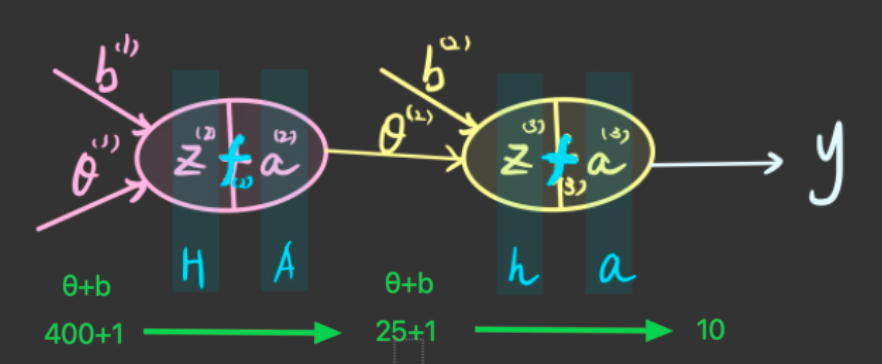

In [38]:
a1, z2, a2, z3, h = forward_propagate(X=X,theta=theta)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [39]:
def backpropagation(theta, X, y):
    # 还原序列化后的数据
    theta1, theta2 = deserialize(theta)
    
    m = X.shape[0]   # m=5000 共有5000个测试样例
    # 计算净输入z 与 激活值a
    a1, z2, a2, z3, h = forward_propagate(X=X,theta=theta)
    
    # △会累计我们在偏导数项
    delta_1 = np.zeros(theta1.shape)     #(25,401)
    delta_2 = np.zeros(theta2.shape)     #(10,26)
        
    for i in range(m):
        # 取出每一行
        a1_i = a1[i,:]    # (1,401)
        z2_i = z2[i,:]    # (1,25)
        a2_i = a2[i,:]    # (1,26)
       # z3_i = z3[i,:]    # (1,10)
        h_i = h[i,:]      # (1,10)
        y_i = y[i,:]      # (1,10)
        
        # 计算每一层的误差项δ局
        #   δ_1:无(1-2)  δ_2:(2-3)  δ_3:(2-h)
        
        
        # 对于最后一层(第三层)
        d_3 = h_i - y_i  # (1,10)
        
        
        # 对于隐藏层（第二层）
        z2_i = np.insert(z2_i,0,values=np.ones(1))  #(1,26)
        # θ2(10,26) -> (1,10) * (10,26) ->(1,26)
        d_2 = np.multiply(d_3 * theta2, sigmoid_gradient(z2_i))
        
        # 累加偏导数
        delta_1 = delta_1 + (d_2[:,1:]).T * (a1_i)  # (25,1) * (1,401)  ->(25,401)
        delta_2 = delta_2 + (d_3.T) * a2_i  # (10,1) * (1,26) ->(10,26)
            
    delta_1 = delta_1 / m
    delta_2 = delta_2 / m
    
    # 序列化
    grad = np.concatenate((np.ravel(delta_1), np.ravel(delta_2)))
    return grad

In [40]:
grad = backpropagation(theta,X,y_onehot)
deserialize(grad)[0].shape,deserialize(grad)[1].shape

((25, 401), (10, 26))

## 正则化神经网络 Regularized Neural Networks

反向传播算法中应用`正则化`参数，根据$j$是否等于0来分两种情况计算
$$
\begin{array}{ll}
\frac{\partial}{\partial \Theta_{i j}^{(l)}} J(\Theta)=D_{i j}^{(l)}=\frac{1}{m} \Delta_{i j}^{(l)} & \text { for } j=0 \\
\frac{\partial}{\partial \Theta_{i j}^{(l)}} J(\Theta)=D_{i j}^{(l)}=\frac{1}{m} \Delta_{i j}^{(l)}+\frac{\lambda}{m} \Theta_{i j}^{(l)} & \text { for } j \geq 1
\end{array}
$$
当$j=0$时对应偏差项，因此没有加上额外的标准化项。

In [41]:
theta_1, theta_2 = deserialize(theta)
theta_1.shape, theta_2.shape

((25, 401), (10, 26))

In [42]:
def NN_Reg(theta,X,y,Rate):
    m = X.shape[0]   # m=5000 共有5000个测试样例
    theta_1, theta_2 = deserialize(theta)
    delta_1, delta_2 = deserialize(backpropagation(theta,X,y))
    
    
    # 添加正则项
    reg_1 = (Rate * theta_1[:,1:]) / m
    reg_2 = (Rate * theta_2[:,1:]) / m
    
    delta_1[:,1:] = delta_1[:,1:] + reg_1
    delta_2[:,1:] = delta_2[:,1:] + reg_2
    
    grad = np.concatenate((np.ravel(delta_1), np.ravel(delta_2)))
    return grad

In [43]:
grad = NN_Reg(theta,X,y_onehot,learningRate)
grad.shape

(10285,)

## 最小化代价函数

In [44]:
# x0参数必须是一维数组，但我给了它二维数组。
# 因此，只需在backpropagation中将initial_theta更改为1D并将其重塑为2D 或者 使用原始的randomParams
randomParams.shape

(10285,)

In [45]:
import scipy.optimize as opt

fmin = opt.minimize(fun=computerCostReg,
                    x0=randomParams,
                    args=(X,y_onehot,learningRate),
                    method='TNC',
                    jac=NN_Reg,
                    options={'maxiter': 250}   # 用来控制最大的迭代次数，以字典的形式来进行设置，
                   )

In [46]:
fmin

     fun: 0.21577056266379097
     jac: array([-8.75067652e-05, -8.16097312e-07,  9.98090272e-07, ...,
        1.32158003e-04,  2.96488034e-04,  8.94139719e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 19
  status: 3
 success: False
       x: array([-1.06462042, -0.00408049,  0.00499045, ..., -0.05776589,
        3.86633347, -1.27573397])

由于目标函数不太可能完全收敛，我们对迭代次数进行了限制。 我们的总代价已经下降到0.5以下，这是算法正常工作的一个很好的指标。 

In [47]:
theta_min = fmin.x
theta_1, theta_2 = deserialize(theta_min)
theta_1.shape,theta_2.shape

((25, 401), (10, 26))

In [48]:
a1, z2, a2, z3, h = forward_propagate(X=X,theta=theta_min)
y_pred = predict(h)
y_pred[:10].ravel()

matrix([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

In [49]:
y_answer = df['y']
y_answer[:10].ravel()

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=uint8)

###  用训练集预测和验证

通过网络前向传播以获得预测

In [50]:
acc,accList = accuracy(predictions=y_pred,y=y_answer)
print('精准度为{}%'.format(acc*100))

精准度为99.42%


In [51]:
from sklearn.metrics import classification_report#这个包是评价报告
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       0.99      0.99      0.99       500
           4       0.98      0.99      0.99       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       1.00      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



由此可见精准度大于前馈预测得到的精准度为97.52%

## 显示隐藏层 Visualizing the hidden layer

In [52]:
def plot_hidden_layer(theta):
    theta_1, theta_2 = deserialize(theta)  # ((25, 401), (10, 26))
    hidden_layer = theta_1[:, 1:]  

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for i in range(5):
        for j in range(5):
            ax_array[i, j].matshow(hidden_layer[5 * i + j].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


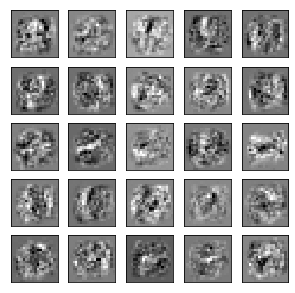

In [53]:
plot_hidden_layer(theta_min)
plt.show()